In [ ]:
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, RandomHorizontalFlip, Compose #, Normalize() if needed
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
training_data = CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose([RandomHorizontalFlip(), ToTensor()]) # Normalize() if needed
    # transform=ToTensor()

)

test_data = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose([RandomHorizontalFlip(), ToTensor()])
    # transform=ToTensor()
)

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


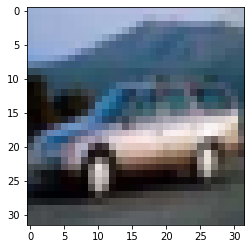

In [ ]:
# test random flip
plt.imshow(training_data[4][0].permute(1, 2, 0))

In [ ]:
# dane są unormowane do 0-1
training_data[1][0].min(), training_data[1][0].max()

(tensor(0.0196), tensor(0.9961))

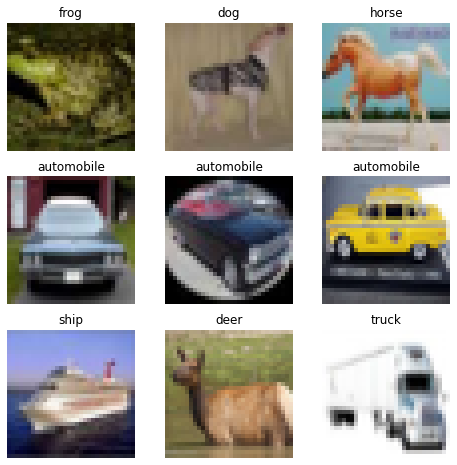

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(img.movedim(0,2), cmap="gray_r")
plt.show()

In [ ]:
# zestaw jest już zrównoważony
bc = torch.bincount(torch.tensor(training_data.targets))
print(bc)

# gdyby nie był, można by użyć straty z wagami
#weights = 1 / bc
#weights = weights / weights.sum()
weights = None

tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])


In [ ]:
# tylko zestaw treningowy jest mieszany
training_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
class ResidualDownBlock(nn.Module):
    """
    Downsampling convolutional block with residual connection.
    (N, C, W, H) -> (N, 2*C, W/2, H/2)
    """

    def __init__(self, in_channels):
        super(ResidualDownBlock, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, 2*in_channels,
                      kernel_size=3, padding=1, bias=False),    # (N x C x W x H) -> (N x 2C x W x H)
            nn.BatchNorm2d(2*in_channels),
            nn.ReLU(),
            nn.Conv2d(2*in_channels, 2*in_channels,
                      kernel_size=3, stride=2, padding=1, bias=False),  # (N x 2C x W x H) -> (N x 2C x W/2 x H/2)
            nn.BatchNorm2d(2*in_channels),
        )
        self.relu = nn.ReLU()

        self.identity_downsample = nn.Sequential(
            # downsample (N x C x W x H) -> (N x C x W/2 x H/2)
            nn.MaxPool2d(2),
            # projection (N x C x W x H/2) -> (N x 2C x W/2 x H/2)
            nn.Conv2d(in_channels, 2*in_channels, 1)
        )

    def forward(self, x):
        I = self.identity_downsample(x)
        x = self.seq(x)
        x += I
        x = self.relu(x)
        return x


In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=1, stride=1, padding=0),
    ResidualDownBlock(16),
    ResidualDownBlock(32),
    ResidualDownBlock(64),
    nn.Flatten(),
    # nn.Dropout(0.2),
    nn.Linear(128 * 4 * 4, 64),
    nn.ReLU(),
    # nn.Dropout(0.2),
    nn.Linear(64, 10)
).to(device)

In [ ]:
loss = nn.CrossEntropyLoss(weight=weights.to(device) if weights is not None else None) # przekazujemy wagi, jeśli zostały wyliczone
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_history = []

In [ ]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for X, y in training_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        l = loss(pred, y)
        total_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    loss_history.append(total_loss / len(training_dataloader))
    print(f"Epoch {epoch + 1}, Loss: {loss_history[-1]:.4f}")

Epoch 1, Loss: 1.2678
Epoch 2, Loss: 0.8237
Epoch 3, Loss: 0.6788
Epoch 4, Loss: 0.5791
Epoch 5, Loss: 0.5079
Epoch 6, Loss: 0.4428
Epoch 7, Loss: 0.3922
Epoch 8, Loss: 0.3479
Epoch 9, Loss: 0.3110
Epoch 10, Loss: 0.2782


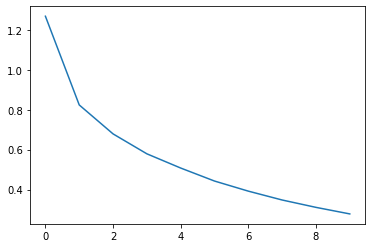

In [ ]:
plt.plot(loss_history)

In [ ]:
def accuracy(model, dataloader):
    correct = 0
    total = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        correct += (pred.argmax(1) == y).sum().item()
        total += len(X)
    return correct / total

In [ ]:
accuracy(model, training_dataloader), accuracy(model, test_dataloader)

(0.91616, 0.8002)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def my_confusion_matrix(dataloader, classes):
    cm = np.zeros((classes, classes))
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y_pred = model(X).argmax(dim=1).cpu()
            cm += confusion_matrix(y, y_pred, labels=list(range(classes)))
    return cm.astype(int)

In [ ]:
cm = my_confusion_matrix(test_dataloader, 10)
print(cm)

[[829   8  27  26  38   7   4  20  17  24]
 [ 17 868   2   1   3   9   8   8  10  74]
 [ 51   1 649  68 104  57  31  30   3   6]
 [ 11   2  30 661  65 154  31  36   4   6]
 [ 11   0  29  39 847  22  17  34   1   0]
 [  3   0  18 147  49 746   5  31   1   0]
 [  5   0  24  69  50  21 818  11   2   0]
 [  5   0   7  22  62  30   2 870   0   2]
 [ 71  15   7  17  13   6   7   7 835  22]
 [ 24  21   4  18   3   7   3  21  15 884]]


In [ ]:
# calculate roc curve and auc
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def my_roc_curve(dataloader, classes):
    y_score = np.zeros((0, classes))
    y_true = np.zeros((0, classes))
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y_score = np.concatenate((y_score, model(X).cpu()), axis=0)
            y_true = np.concatenate((y_true, label_binarize(y, classes=list(range(classes)))), axis=0)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc, classes):
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average(area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

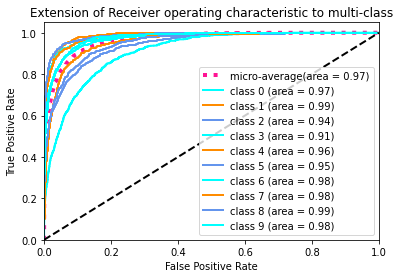

In [ ]:
fpr, tpr, roc_auc = my_roc_curve(test_dataloader, 10)
plot_roc_curve(fpr, tpr, roc_auc, 10)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)